# K리그 승리확률 & 전술 시뮬레이터

이 노트북은 K리그 팀별 승리확률 예측 및 전술 시뮬레이션 시스템을 구현합니다.

## 목표
1. 팀별 경기별 피처 테이블 생성
2. 매치업 피처 계산 (최근 폼 + 상대팀 비교)
3. 승리확률 모델 학습
4. 팀 강점/약점 분석 리포트
5. 전술 레버 시뮬레이션 (What-if 분석)


In [68]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from src.data_loader import load_raw_events, load_match_info, save_processed

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로딩 완료")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ 라이브러리 로딩 완료


## STEP 1: 팀 × 경기 피처 테이블 생성

각 팀의 경기별 공격/빌드업/수비/리스크 지표를 계산합니다.


In [69]:
# 데이터 로딩
print("데이터 로딩 중...")
events = load_raw_events()
match_info = load_match_info()

print(f"이벤트 데이터: {len(events):,}개")
print(f"경기 정보: {len(match_info):,}개")
print(f"\n이벤트 타입: {events['type_name'].unique()}")
print(f"결과 타입: {events['result_name'].dropna().unique()}")


데이터 로딩 중...
이벤트 데이터: 579,306개
경기 정보: 198개

이벤트 타입: ['Pass' 'Pass Received' 'Carry' 'Block' 'Out' 'Throw-In' 'Intervention'
 'Recovery' 'Interception' 'Clearance' 'Duel' 'Tackle' 'Offside'
 'Pass_Freekick' 'Error' 'Foul' 'Cross' 'Goal Kick' 'Shot'
 'Aerial Clearance' 'Catch' 'Take-On' 'Pause' 'Ball Received' 'Parry'
 'Pass_Corner' 'Hit' 'Defensive Line Support' 'Goal Miss' 'Goal'
 'Deflection' 'Penalty Kick' 'Goal Post' 'Handball_Foul' 'Shot_Freekick'
 'Own Goal' 'Foul_Throw']
결과 타입: ['Successful' 'Unsuccessful' 'Off Target' 'Yellow_Card' 'On Target'
 'Blocked' 'Low Quality Shot' 'Goal' 'Direct_Red_Card' 'Keeper Rush-Out'
 'Second_Yellow_Card']


In [70]:
def build_team_match_features(events_df, match_info_df):
    """
    팀별 경기별 피처 테이블 생성
    
    Returns:
        DataFrame: game_id, team, features..., goals_for, goals_against, is_home, result
    """
    # 경기 정보와 이벤트 데이터 병합
    match_info_expanded = match_info_df.copy()
    
    # 홈팀과 어웨이팀 각각에 대한 행 생성
    home_rows = match_info_expanded.copy()
    home_rows['team'] = home_rows['home_team_name_ko']
    home_rows['goals_for'] = home_rows['home_score']
    home_rows['goals_against'] = home_rows['away_score']
    home_rows['is_home'] = True
    home_rows['opponent'] = home_rows['away_team_name_ko']
    
    away_rows = match_info_expanded.copy()
    away_rows['team'] = away_rows['away_team_name_ko']
    away_rows['goals_for'] = away_rows['away_score']
    away_rows['goals_against'] = away_rows['home_score']
    away_rows['is_home'] = False
    away_rows['opponent'] = away_rows['home_team_name_ko']
    
    # 결과 계산
    def calc_result(row):
        if row['goals_for'] > row['goals_against']:
            return 'win'
        elif row['goals_for'] < row['goals_against']:
            return 'loss'
        else:
            return 'draw'
    
    home_rows['result'] = home_rows.apply(calc_result, axis=1)
    away_rows['result'] = away_rows.apply(calc_result, axis=1)
    
    # 경기별 팀 데이터프레임 생성
    team_matches = pd.concat([home_rows, away_rows], ignore_index=True)
    
    # 각 경기별 팀별 피처 계산
    features_list = []
    
    for _, match_row in team_matches.iterrows():
        game_id = match_row['game_id']
        team = match_row['team']
        
        # 해당 경기의 해당 팀 이벤트만 필터링
        team_events = events_df[
            (events_df['game_id'] == game_id) & 
            (events_df['team_name_ko'] == team)
        ].copy()
        
        if len(team_events) == 0:
            continue
        
        # ========== 공격 피처 ==========
        shots = team_events[team_events['type_name'] == 'Shot']
        shots_attempted = len(shots)
        shots_on_target = len(shots[shots['result_name'] == 'Successful'])
        goals = len(shots[shots['result_name'] == 'Goal'])
        
        # Box entries: 박스 밖에서 박스 안으로 성공한 패스/캐리
        # 박스 좌표: x >= 83.3, y >= 21.1 and y <= 78.9 (정규화된 좌표 기준)
        passes_carries = team_events[
            (team_events['type_name'].isin(['Pass', 'Carry'])) &
            (team_events['result_name'] == 'Successful')
        ]
        box_entries = len(passes_carries[
            (passes_carries['start_x'] < 83.3) & 
            (passes_carries['end_x'] >= 83.3) &
            (passes_carries['end_y'] >= 21.1) &
            (passes_carries['end_y'] <= 78.9)
        ])
        
        # Final third entries: x < 66.7에서 x >= 66.7로 성공한 패스/캐리
        final_third_entries = len(passes_carries[
            (passes_carries['start_x'] < 66.7) & 
            (passes_carries['end_x'] >= 66.7)
        ])
        
        # 크로스 시도 및 성공률
        crosses = team_events[team_events['type_name'] == 'Cross']
        crosses_attempted = len(crosses)
        crosses_successful = len(crosses[crosses['result_name'] == 'Successful'])
        crosses_success_rate = crosses_successful / crosses_attempted if crosses_attempted > 0 else 0.0
        
        # Progressive passes: 전진 거리 10 이상 또는 최종 1/3 진입
        progressive_passes = passes_carries[
            ((passes_carries['end_x'] - passes_carries['start_x'] >= 10) |
             (passes_carries['start_x'] < 66.7) & (passes_carries['end_x'] >= 66.7))
        ]
        progressive_passes_success = len(progressive_passes)
        
        # ========== 빌드업 피처 ==========
        passes = team_events[team_events['type_name'] == 'Pass']
        passes_attempted = len(passes)
        passes_successful = len(passes[passes['result_name'] == 'Successful'])
        pass_success_rate = passes_successful / passes_attempted if passes_attempted > 0 else 0.0
        
        # Long passes: 거리 25 이상
        long_passes = passes[
            np.sqrt((passes['end_x'] - passes['start_x'])**2 + 
                   (passes['end_y'] - passes['start_y'])**2) >= 25
        ]
        long_pass_attempted = len(long_passes)
        
        # ========== 수비 피처 ==========
        recoveries = len(team_events[team_events['type_name'] == 'Recovery'])
        interceptions = len(team_events[team_events['type_name'] == 'Interception'])
        tackles = len(team_events[team_events['type_name'] == 'Tackle'])
        
        # Duels 성공률
        duels = team_events[team_events['type_name'] == 'Duel']
        duels_attempted = len(duels)
        duels_successful = len(duels[duels['result_name'] == 'Successful'])
        duels_success_rate = duels_successful / duels_attempted if duels_attempted > 0 else 0.0
        
        # ========== 리스크 피처 ==========
        # Defensive third turnovers: 수비 1/3에서 실패한 패스 또는 실패한 캐리
        defensive_third_events = team_events[
            (team_events['start_x'] < 33.3) &
            (team_events['type_name'].isin(['Pass', 'Carry']))
        ]
        defensive_third_turnovers = len(
            defensive_third_events[defensive_third_events['result_name'] != 'Successful']
        )
        
        # 피처 딕셔너리 생성
        features = {
            'game_id': game_id,
            'team': team,
            'opponent': match_row['opponent'],
            'is_home': match_row['is_home'],
            'goals_for': match_row['goals_for'],
            'goals_against': match_row['goals_against'],
            'result': match_row['result'],
            # 공격
            'shots': shots_attempted,
            'shots_on_target': shots_on_target,
            'goals': goals,
            'box_entries': box_entries,
            'final_third_entries': final_third_entries,
            'crosses_attempted': crosses_attempted,
            'crosses_success_rate': crosses_success_rate,
            'progressive_passes_success': progressive_passes_success,
            # 빌드업
            'passes_attempted': passes_attempted,
            'pass_success_rate': pass_success_rate,
            'long_pass_attempted': long_pass_attempted,
            # 수비
            'recoveries': recoveries,
            'interceptions': interceptions,
            'tackles': tackles,
            'duels_success_rate': duels_success_rate,
            # 리스크
            'defensive_third_turnovers': defensive_third_turnovers,
        }
        
        features_list.append(features)
    
    features_df = pd.DataFrame(features_list)
    return features_df

# 피처 테이블 생성
print("팀별 경기별 피처 계산 중... (시간이 걸릴 수 있습니다)")
team_match_features = build_team_match_features(events, match_info)

print(f"\n✅ 피처 테이블 생성 완료: {len(team_match_features)}개 행")
print(f"컬럼: {list(team_match_features.columns)}")
print(f"\n샘플 데이터:")
print(team_match_features.head())


팀별 경기별 피처 계산 중... (시간이 걸릴 수 있습니다)

✅ 피처 테이블 생성 완료: 396개 행
컬럼: ['game_id', 'team', 'opponent', 'is_home', 'goals_for', 'goals_against', 'result', 'shots', 'shots_on_target', 'goals', 'box_entries', 'final_third_entries', 'crosses_attempted', 'crosses_success_rate', 'progressive_passes_success', 'passes_attempted', 'pass_success_rate', 'long_pass_attempted', 'recoveries', 'interceptions', 'tackles', 'duels_success_rate', 'defensive_third_turnovers']

샘플 데이터:
   game_id       team   opponent  is_home  goals_for  goals_against result  \
0   126283   울산 HD FC    포항 스틸러스     True          1              0    win   
1   126284  전북 현대 모터스  대전 하나 시티즌     True          1              1   draw   
2   126285       광주FC       FC서울     True          2              0    win   
3   126286   인천 유나이티드       수원FC     True          0              1   loss   
4   126287       강원FC    제주SK FC     True          1              1   draw   

   shots  shots_on_target  goals  ...  crosses_success_rate  \
0     1

In [71]:
# 피처 테이블 저장
save_processed(team_match_features, "team_match_features.csv")
print("✅ team_match_features.csv 저장 완료")

# 기본 통계 확인
print("\n=== 기본 통계 ===")
print(team_match_features.describe())
print("\n=== 결과 분포 ===")
print(team_match_features['result'].value_counts())


✅ team_match_features.csv 저장 완료

=== 기본 통계 ===
             game_id   goals_for  goals_against       shots  shots_on_target  \
count     396.000000  396.000000     396.000000  396.000000            396.0   
mean   126381.500000    1.345960       1.345960   11.063131              0.0   
std        57.229253    1.155727       1.155727    4.524315              0.0   
min    126283.000000    0.000000       0.000000    2.000000              0.0   
25%    126332.000000    0.000000       0.000000    8.000000              0.0   
50%    126381.500000    1.000000       1.000000   11.000000              0.0   
75%    126431.000000    2.000000       2.000000   13.250000              0.0   
max    126480.000000    6.000000       6.000000   29.000000              0.0   

            goals  box_entries  final_third_entries  crosses_attempted  \
count  396.000000   396.000000           396.000000         396.000000   
mean     1.166667    11.527778            27.929293          15.563131   
std      1

## STEP 2: 매치업 피처 (최근 폼 + 상대팀 비교)

각 팀의 최근 5경기 평균과 상대팀과의 차이를 계산합니다.


In [72]:
def build_matchup_features(team_match_features_df, n_recent=5):
    """
    매치업 피처 생성: 최근 폼 + 상대팀 비교
    
    Parameters:
        team_match_features_df: 팀별 경기별 피처 테이블
        n_recent: 최근 N경기 평균 계산
    
    Returns:
        DataFrame: 매치업별 피처 (team A vs team B)
    """
    # 경기 날짜 정보 추가 (game_id 순서로 시간 순서 가정)
    # 실제로는 match_info의 game_date를 사용해야 하지만, 여기서는 game_id로 정렬
    team_match_features = team_match_features_df.copy()
    team_match_features = team_match_features.sort_values('game_id')
    
    # 피처 컬럼 (수치형만)
    feature_cols = [
        'shots', 'shots_on_target', 'goals', 'box_entries', 'final_third_entries',
        'crosses_attempted', 'crosses_success_rate', 'progressive_passes_success',
        'passes_attempted', 'pass_success_rate', 'long_pass_attempted',
        'recoveries', 'interceptions', 'tackles', 'duels_success_rate',
        'defensive_third_turnovers'
    ]
    
    matchup_list = []
    
    # 각 경기별로 매치업 피처 생성
    for game_id in team_match_features['game_id'].unique():
        game_data = team_match_features[team_match_features['game_id'] == game_id]
        
        if len(game_data) != 2:  # 홈/어웨이 2팀이어야 함
            continue
        
        home_team = game_data[game_data['is_home'] == True].iloc[0]
        away_team = game_data[game_data['is_home'] == False].iloc[0]
        
        team_a = home_team['team']
        team_b = away_team['team']
        
        # 팀 A의 최근 N경기 평균 계산
        team_a_past = team_match_features[
            (team_match_features['team'] == team_a) &
            (team_match_features['game_id'] < game_id)
        ].tail(n_recent)
        
        # 팀 B의 최근 N경기 평균 계산
        team_b_past = team_match_features[
            (team_match_features['team'] == team_b) &
            (team_match_features['game_id'] < game_id)
        ].tail(n_recent)
        
        # 팀 A의 평균 피처
        team_a_avg = {}
        for col in feature_cols:
            if len(team_a_past) > 0:
                team_a_avg[f'{col}_avg'] = team_a_past[col].mean()
            else:
                team_a_avg[f'{col}_avg'] = 0.0
        
        # 팀 B의 평균 피처
        team_b_avg = {}
        for col in feature_cols:
            if len(team_b_past) > 0:
                team_b_avg[f'{col}_avg'] = team_b_past[col].mean()
            else:
                team_b_avg[f'{col}_avg'] = 0.0
        
        # 상대팀이 허용한 평균 (팀 B를 상대한 팀들의 평균)
        team_b_opponents_past = team_match_features[
            (team_match_features['opponent'] == team_b) &
            (team_match_features['game_id'] < game_id)
        ].tail(n_recent)
        
        team_b_conceded_avg = {}
        for col in feature_cols:
            if len(team_b_opponents_past) > 0:
                team_b_conceded_avg[f'{col}_conceded_avg'] = team_b_opponents_past[col].mean()
            else:
                team_b_conceded_avg[f'{col}_conceded_avg'] = 0.0
        
        # 차이 피처 (팀 A 강점 - 팀 B 약점)
        diff_features = {}
        for col in feature_cols:
            # 공격/빌드업 지표는 높을수록 좋음
            if col in ['shots', 'shots_on_target', 'goals', 'box_entries', 'final_third_entries',
                      'crosses_attempted', 'crosses_success_rate', 'progressive_passes_success',
                      'passes_attempted', 'pass_success_rate', 'long_pass_attempted',
                      'recoveries', 'interceptions', 'tackles', 'duels_success_rate']:
                diff_features[f'diff_{col}'] = team_a_avg[f'{col}_avg'] - team_b_conceded_avg[f'{col}_conceded_avg']
            # 리스크 지표는 낮을수록 좋음
            elif col == 'defensive_third_turnovers':
                diff_features[f'diff_{col}'] = team_b_conceded_avg[f'{col}_conceded_avg'] - team_a_avg[f'{col}_avg']
        
        # 매치업 피처 조합
        matchup_feat = {
            'game_id': game_id,
            'team_a': team_a,
            'team_b': team_b,
            'is_home': True,  # team_a가 홈
            **team_a_avg,
            **team_b_avg,
            **team_b_conceded_avg,
            **diff_features,
            'actual_result': home_team['result']  # 실제 결과 (win/loss/draw)
        }
        
        matchup_list.append(matchup_feat)
    
    matchup_df = pd.DataFrame(matchup_list)
    return matchup_df

# 매치업 피처 생성
print("매치업 피처 계산 중...")
matchup_features = build_matchup_features(team_match_features, n_recent=5)

print(f"\n✅ 매치업 피처 생성 완료: {len(matchup_features)}개 행")
print(f"컬럼 수: {len(matchup_features.columns)}")
print(f"\n샘플 데이터:")
print(matchup_features[['game_id', 'team_a', 'team_b', 'actual_result']].head())


매치업 피처 계산 중...

✅ 매치업 피처 생성 완료: 198개 행
컬럼 수: 53

샘플 데이터:
   game_id     team_a     team_b actual_result
0   126283   울산 HD FC    포항 스틸러스           win
1   126284  전북 현대 모터스  대전 하나 시티즌          draw
2   126285       광주FC       FC서울           win
3   126286   인천 유나이티드       수원FC          loss
4   126287       강원FC    제주SK FC          draw


In [73]:
# 매치업 피처 저장
save_processed(matchup_features, "matchup_features.csv")
print("✅ matchup_features.csv 저장 완료")


✅ matchup_features.csv 저장 완료


## STEP 3: 승리확률 모델 학습

Logistic Regression과 LightGBM을 사용하여 승리확률 모델을 학습합니다.


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import lightgbm as lgb

def prepare_model_data(matchup_df):
    """모델 학습용 데이터 준비"""
    # diff_ 피처만 선택
    feature_cols = [col for col in matchup_df.columns if col.startswith('diff_')]
    
    X = matchup_df[feature_cols].fillna(0)
    y = (matchup_df['actual_result'] == 'win').astype(int)  # 승리 = 1, 무승부/패배 = 0
    
    return X, y, feature_cols

# 데이터 준비
X, y, feature_cols = prepare_model_data(matchup_features)

print(f"피처 수: {len(feature_cols)}")
print(f"샘플 수: {len(X)}")
print(f"승리 비율: {y.mean():.2%}")
print(f"\n피처 목록:")
print(feature_cols)


피처 수: 16
샘플 수: 198
승리 비율: 45.96%

피처 목록:
['diff_shots', 'diff_shots_on_target', 'diff_goals', 'diff_box_entries', 'diff_final_third_entries', 'diff_crosses_attempted', 'diff_crosses_success_rate', 'diff_progressive_passes_success', 'diff_passes_attempted', 'diff_pass_success_rate', 'diff_long_pass_attempted', 'diff_recoveries', 'diff_interceptions', 'diff_tackles', 'diff_duels_success_rate', 'diff_defensive_third_turnovers']


In [75]:
# 시간 기반 train/test split (game_id 기준)
sorted_indices = matchup_features.sort_values('game_id').index
split_idx = int(len(sorted_indices) * 0.8)

train_indices = sorted_indices[:split_idx]
test_indices = sorted_indices[split_idx:]

X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

print(f"Train: {len(X_train)}개, Test: {len(X_test)}개")


Train: 158개, Test: 40개


In [76]:
# Model 1: Logistic Regression
print("=" * 50)
print("Model 1: Logistic Regression")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 교차 검증으로 보정
lr_calibrated = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)
lr_calibrated.fit(X_train_scaled, y_train)

# 예측
y_pred_lr = lr_calibrated.predict(X_test_scaled)
y_proba_lr = lr_calibrated.predict_proba(X_test_scaled)[:, 1]

# 평가
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# 피처 중요도 (계수 절댓값)
lr_coef = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0]
})
lr_coef['abs_coef'] = np.abs(lr_coef['coefficient'])
lr_coef = lr_coef.sort_values('abs_coef', ascending=False)

print("\n상위 10개 중요 피처:")
print(lr_coef.head(10))


Model 1: Logistic Regression
Accuracy: 0.5250
ROC-AUC: 0.4750

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.95      0.67        20
           1       0.67      0.10      0.17        20

    accuracy                           0.53        40
   macro avg       0.59      0.53      0.42        40
weighted avg       0.59      0.53      0.42        40


상위 10개 중요 피처:
                            feature  coefficient  abs_coef
9            diff_pass_success_rate     0.371820  0.371820
6         diff_crosses_success_rate     0.263401  0.263401
0                        diff_shots    -0.230522  0.230522
7   diff_progressive_passes_success    -0.222429  0.222429
5            diff_crosses_attempted    -0.214733  0.214733
12               diff_interceptions     0.178314  0.178314
2                        diff_goals    -0.147523  0.147523
8             diff_passes_attempted     0.147033  0.147033
15   diff_defensive_third_turnovers    -0

In [77]:
# Model 2: LightGBM
print("\n" + "=" * 50)
print("Model 2: LightGBM")
print("=" * 50)

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

# 예측
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# 평가
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))

# 피처 중요도
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n상위 10개 중요 피처:")
print(lgb_importance.head(10))



Model 2: LightGBM
Accuracy: 0.6500
ROC-AUC: 0.6750

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.69      0.55      0.61        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40


상위 10개 중요 피처:
                           feature  importance
13                    diff_tackles          21
6        diff_crosses_success_rate          19
11                 diff_recoveries          13
5           diff_crosses_attempted          13
12              diff_interceptions          12
10        diff_long_pass_attempted          10
4         diff_final_third_entries           8
15  diff_defensive_third_turnovers           8
9           diff_pass_success_rate           8
0                       diff_shots           7


In [78]:
# 최종 모델 선택 (LightGBM이 더 좋은 성능을 보이면 사용)
if roc_auc_score(y_test, y_proba_lgb) > roc_auc_score(y_test, y_proba_lr):
    print("✅ 최종 모델: LightGBM 선택")
    final_model = lgb_model
    final_scaler = None
    use_scaler = False
else:
    print("✅ 최종 모델: Logistic Regression 선택")
    final_model = lr_calibrated
    final_scaler = scaler
    use_scaler = True

def predict_win_probability(matchup_row, model, scaler=None, feature_cols=None):
    """
    단일 매치업에 대한 승리확률 예측
    
    Parameters:
        matchup_row: 매치업 피처 행 (Series 또는 dict)
        model: 학습된 모델
        scaler: StandardScaler (Logistic Regression용)
        feature_cols: 피처 컬럼 리스트
    
    Returns:
        float: 승리확률 (0-1)
    """
    if feature_cols is None:
        if isinstance(matchup_row, pd.Series):
            feature_cols = [col for col in matchup_row.index if col.startswith('diff_')]
        else:
            feature_cols = [col for col in matchup_row.keys() if col.startswith('diff_')]
    
    # Series를 dict로 변환하여 안전하게 처리
    if isinstance(matchup_row, pd.Series):
        matchup_dict = matchup_row.to_dict()
    else:
        matchup_dict = matchup_row
    
    # feature_cols 순서대로 값 추출
    X_values = [matchup_dict.get(col, 0) for col in feature_cols]
    X = pd.DataFrame([X_values], columns=feature_cols).fillna(0)
    
    if scaler is not None:
        X = scaler.transform(X)
    
    proba = model.predict_proba(X)[0, 1]
    return proba


✅ 최종 모델: LightGBM 선택


## STEP 4: 강점 & 약점 분석 리포트

팀의 강점과 상대팀의 약점을 분석하여 매치업 인사이트를 생성합니다.


In [79]:
def analyze_team_strengths(team_match_features_df, team_name, n_recent=5):
    """
    팀의 최근 강점 분석 (리그 평균 대비)
    
    Returns:
        dict: 강점 지표 (상위 3개)
    """
    team_recent = team_match_features_df[
        team_match_features_df['team'] == team_name
    ].tail(n_recent)
    
    if len(team_recent) == 0:
        return {}
    
    # 리그 평균 계산 (수치형 컬럼만)
    league_avg = team_match_features_df.groupby('game_id').mean(numeric_only=True)
    
    # 공격/빌드업/수비 지표
    attack_metrics = ['shots', 'shots_on_target', 'box_entries', 'final_third_entries',
                     'progressive_passes_success', 'crosses_success_rate']
    build_metrics = ['pass_success_rate', 'long_pass_attempted']
    defense_metrics = ['recoveries', 'interceptions', 'tackles', 'duels_success_rate']
    
    strengths = {}
    
    for metric in attack_metrics + build_metrics + defense_metrics:
        team_avg = team_recent[metric].mean()
        league_avg_val = league_avg[metric].mean()
        diff = team_avg - league_avg_val
        if diff > 0:  # 리그 평균보다 높으면 강점
            strengths[metric] = {
                'value': team_avg,
                'league_avg': league_avg_val,
                'diff': diff,
                'diff_pct': (diff / league_avg_val * 100) if league_avg_val > 0 else 0
            }
    
    # 상위 3개 강점
    top_strengths = sorted(strengths.items(), key=lambda x: x[1]['diff'], reverse=True)[:3]
    return dict(top_strengths)

def analyze_opponent_weaknesses(team_match_features_df, opponent_name, n_recent=5):
    """
    상대팀의 최근 약점 분석 (허용한 지표 기준)
    
    Returns:
        dict: 약점 지표 (하위 3개, 즉 많이 허용한 지표)
    """
    # 상대팀을 상대한 팀들의 지표 (상대팀이 허용한 것)
    opponent_games = team_match_features_df[
        team_match_features_df['opponent'] == opponent_name
    ].tail(n_recent)
    
    if len(opponent_games) == 0:
        return {}
    
    # 리그 평균 계산 (수치형 컬럼만)
    league_avg = team_match_features_df.groupby('game_id').mean(numeric_only=True)
    
    weaknesses = {}
    
    # 공격 지표: 상대팀이 많이 허용하면 약점
    attack_metrics = ['shots', 'shots_on_target', 'box_entries', 'final_third_entries',
                     'progressive_passes_success']
    
    for metric in attack_metrics:
        opponent_conceded = opponent_games[metric].mean()
        league_avg_val = league_avg[metric].mean()
        diff = opponent_conceded - league_avg_val
        if diff > 0:  # 리그 평균보다 많이 허용하면 약점
            weaknesses[metric] = {
                'conceded': opponent_conceded,
                'league_avg': league_avg_val,
                'diff': diff,
                'diff_pct': (diff / league_avg_val * 100) if league_avg_val > 0 else 0
            }
    
    # 상위 3개 약점 (많이 허용한 것)
    top_weaknesses = sorted(weaknesses.items(), key=lambda x: x[1]['diff'], reverse=True)[:3]
    return dict(top_weaknesses)

def find_matchup_advantages(team_strengths, opponent_weaknesses):
    """
    팀 강점과 상대팀 약점의 겹치는 부분 찾기
    """
    advantages = []
    for strength_key in team_strengths.keys():
        if strength_key in opponent_weaknesses:
            advantages.append({
                'metric': strength_key,
                'team_strength': team_strengths[strength_key],
                'opponent_weakness': opponent_weaknesses[strength_key]
            })
    return advantages

# 테스트
test_team = "FC서울"
test_opponent = "강원FC"

team_strengths = analyze_team_strengths(team_match_features, test_team)
opponent_weaknesses = analyze_opponent_weaknesses(team_match_features, test_opponent)
advantages = find_matchup_advantages(team_strengths, opponent_weaknesses)

print(f"=== {test_team} 강점 (리그 평균 대비) ===")
for metric, data in team_strengths.items():
    print(f"{metric}: {data['value']:.2f} (리그 평균: {data['league_avg']:.2f}, +{data['diff']:.2f})")

print(f"\n=== {test_opponent} 약점 (허용 지표) ===")
for metric, data in opponent_weaknesses.items():
    print(f"{metric}: {data['conceded']:.2f} 허용 (리그 평균: {data['league_avg']:.2f}, +{data['diff']:.2f})")

print(f"\n=== 매치업 어드밴티지 ===")
for adv in advantages:
    print(f"{adv['metric']}: 팀 강점과 상대팀 약점이 겹침")


=== FC서울 강점 (리그 평균 대비) ===
tackles: 29.80 (리그 평균: 23.98, +5.82)
interceptions: 36.20 (리그 평균: 34.98, +1.22)
duels_success_rate: 1.00 (리그 평균: 1.00, +0.00)

=== 강원FC 약점 (허용 지표) ===
box_entries: 14.80 허용 (리그 평균: 11.53, +3.27)

=== 매치업 어드밴티지 ===


In [80]:
def generate_match_preview(team, opponent, team_match_features_df, matchup_features_df, 
                          model, scaler, feature_cols, n_recent=5):
    """
    매치 프리뷰 리포트 생성
    
    Returns:
        dict: 리포트 내용
    """
    # 강점/약점 분석
    team_strengths = analyze_team_strengths(team_match_features_df, team, n_recent)
    opponent_weaknesses = analyze_opponent_weaknesses(team_match_features_df, opponent, n_recent)
    advantages = find_matchup_advantages(team_strengths, opponent_weaknesses)
    
    # 최근 매치업 피처 찾기 (또는 평균으로 생성)
    # 실제로는 미래 경기이므로 최근 폼 기반으로 매치업 피처 생성
    team_recent = team_match_features_df[
        team_match_features_df['team'] == team
    ].tail(n_recent)
    
    opponent_recent = team_match_features_df[
        team_match_features_df['opponent'] == opponent
    ].tail(n_recent)
    
    # 매치업 피처 생성 (간단 버전)
    matchup_row = {}
    for col in feature_cols:
        base_metric = col.replace('diff_', '')
        if len(team_recent) > 0 and len(opponent_recent) > 0:
            team_val = team_recent[base_metric].mean() if base_metric in team_recent.columns else 0
            opponent_conceded = opponent_recent[base_metric].mean() if base_metric in opponent_recent.columns else 0
            matchup_row[col] = team_val - opponent_conceded
        else:
            matchup_row[col] = 0
    
    matchup_series = pd.Series(matchup_row)
    
    # 승리확률 예측
    win_prob = predict_win_probability(matchup_series, model, scaler, feature_cols)
    
    # 리포트 생성
    report = {
        'team': team,
        'opponent': opponent,
        'win_probability': win_prob,
        'team_strengths': team_strengths,
        'opponent_weaknesses': opponent_weaknesses,
        'matchup_advantages': advantages
    }
    
    return report

# 리포트 생성 테스트
preview = generate_match_preview(
    team="FC서울",
    opponent="강원FC",
    team_match_features_df=team_match_features,
    matchup_features_df=matchup_features,
    model=final_model,
    scaler=final_scaler if use_scaler else None,
    feature_cols=feature_cols,
    n_recent=5
)

print("=" * 60)
print(f"매치 프리뷰: {preview['team']} vs {preview['opponent']}")
print("=" * 60)
print(f"\n기본 승리확률: {preview['win_probability']:.2%}")

print(f"\n【{preview['team']} 강점】")
for metric, data in preview['team_strengths'].items():
    print(f"  • {metric}: 리그 평균 대비 +{data['diff']:.2f} ({data['diff_pct']:.1f}%)")

print(f"\n【{preview['opponent']} 약점】")
for metric, data in preview['opponent_weaknesses'].items():
    print(f"  • {metric}: 리그 평균 대비 +{data['diff']:.2f} 허용")

print(f"\n【핵심 매치업 어드밴티지】")
if preview['matchup_advantages']:
    for adv in preview['matchup_advantages']:
        print(f"  • {adv['metric']}: 강점과 약점이 겹치는 핵심 지표")
else:
    print("  • 겹치는 강점/약점이 없습니다.")


매치 프리뷰: FC서울 vs 강원FC

기본 승리확률: 51.82%

【FC서울 강점】
  • tackles: 리그 평균 대비 +5.82 (24.2%)
  • interceptions: 리그 평균 대비 +1.22 (3.5%)
  • duels_success_rate: 리그 평균 대비 +0.00 (0.0%)

【강원FC 약점】
  • box_entries: 리그 평균 대비 +3.27 허용

【핵심 매치업 어드밴티지】
  • 겹치는 강점/약점이 없습니다.


## STEP 5: 전술 레버 시뮬레이션 (What-if 분석)

특정 전술 지표를 변경했을 때 승리확률 변화를 시뮬레이션합니다.


In [81]:
def simulate_tactical_levers(base_matchup_row, model, scaler, feature_cols, 
                             team_match_features_df, levers=None):
    """
    전술 레버 시뮬레이션
    
    Parameters:
        base_matchup_row: 기본 매치업 피처 (Series)
        model: 학습된 모델
        scaler: StandardScaler
        feature_cols: 피처 컬럼 리스트
        team_match_features_df: 전체 피처 테이블 (리그 통계 계산용)
        levers: dict, 예: {"box_entries": [+1, +2, +3], "shots_on_target": [+1, +2]}
    
    Returns:
        DataFrame: 레버별 승리확률 변화
    """
    if levers is None:
        # 기본 레버 설정
        levers = {
            "box_entries": [+5, +10, +15],
            "shots_on_target": [+3, +5],
            "defensive_third_turnovers": [-5, -10]
        }
    
    # 기본 승리확률 (dict로 변환하여 계산)
    if isinstance(base_matchup_row, pd.Series):
        base_matchup_dict = base_matchup_row.to_dict()
    else:
        base_matchup_dict = base_matchup_row.copy()
    base_prob = predict_win_probability(base_matchup_dict, model, scaler, feature_cols)
    
    # 리그 통계 (현실적인 범위 계산용)
    league_stats = team_match_features_df.describe()
    
    results = []
    
    for lever_name, changes in levers.items():
        diff_col = f"diff_{lever_name}"
        
        if diff_col not in feature_cols:
            print(f"⚠️ 경고: {diff_col} 피처가 없습니다. 건너뜁니다.")
            continue
        
        # base_value 추출 (Series 또는 dict 모두 처리)
        if isinstance(base_matchup_row, pd.Series):
            base_value = base_matchup_row.get(diff_col, 0) if diff_col in base_matchup_row.index else 0
        else:
            base_value = base_matchup_row.get(diff_col, 0)
        
        for change in changes:
            # 새로운 매치업 피처 생성 (dict로 변환하여 안전하게 처리)
            if isinstance(base_matchup_row, pd.Series):
                new_matchup_dict = base_matchup_row.to_dict().copy()
            else:
                new_matchup_dict = base_matchup_row.copy()
            
            # 피처 값 변경
            new_value = base_value + change
            new_matchup_dict[diff_col] = new_value
            
            # 새로운 승리확률 계산
            new_prob = predict_win_probability(new_matchup_dict, model, scaler, feature_cols)
            prob_delta = new_prob - base_prob
            
            # 디버깅: 첫 번째 변경만 출력
            if change == changes[0] and lever_name == list(levers.keys())[0]:
                print(f"\n[디버깅] {diff_col}:")
                print(f"  base_value: {base_value:.4f}")
                print(f"  change: {change}")
                print(f"  new_value: {new_value:.4f}")
                print(f"  base_prob: {base_prob:.6f}")
                print(f"  new_prob: {new_prob:.6f}")
                print(f"  prob_delta: {prob_delta:.6f}")
            
            results.append({
                'lever': lever_name,
                'change': change,
                'base_prob': base_prob,
                'new_prob': new_prob,
                'prob_delta': prob_delta
            })
    
    results_df = pd.DataFrame(results)
    return results_df

# 시뮬레이션 실행
print("전술 레버 시뮬레이션 실행 중...")

# 테스트용 매치업 피처 (FC서울 vs 강원FC)
test_team = "FC서울"
test_opponent = "강원FC"

# 최근 폼 기반 매치업 피처 생성
team_recent = team_match_features[
    team_match_features['team'] == test_team
].tail(5)

opponent_recent = team_match_features[
    team_match_features['opponent'] == test_opponent
].tail(5)

base_matchup = {}
for col in feature_cols:
    base_metric = col.replace('diff_', '')
    if len(team_recent) > 0 and len(opponent_recent) > 0:
        team_val = team_recent[base_metric].mean() if base_metric in team_recent.columns else 0
        opponent_conceded = opponent_recent[base_metric].mean() if base_metric in opponent_recent.columns else 0
        base_matchup[col] = team_val - opponent_conceded
    else:
        base_matchup[col] = 0

base_matchup_series = pd.Series(base_matchup)

# 레버 시뮬레이션
simulation_results = simulate_tactical_levers(
    base_matchup_series,
    final_model,
    final_scaler if use_scaler else None,
    feature_cols,
    team_match_features,
    levers={
        # 공격 피처
        "shots": [+3, +5, +8],
        "shots_on_target": [+2, +4, +6],
        "box_entries": [+5, +10, +15],
        "final_third_entries": [+10, +20, +30],
        "progressive_passes_success": [+10, +20, +30],
        "crosses_attempted": [+3, +6, +9],
        "crosses_success_rate": [+0.05, +0.10, +0.15],
        # 빌드업 피처
        "passes_attempted": [+20, +40, +60],
        "pass_success_rate": [+0.02, +0.04, +0.06],
        "long_pass_attempted": [+5, +10, +15],
        # 수비 피처
        "recoveries": [+5, +10, +15],
        "interceptions": [+3, +6, +9],
        "tackles": [+3, +6, +9],
        "duels_success_rate": [+0.02, +0.04, +0.06],
        # 리스크 피처 (감소가 좋음)
        "defensive_third_turnovers": [-5, -10, -15]
    }
)

print("\n" + "=" * 60)
print(f"전술 레버 시뮬레이션 결과: {test_team} vs {test_opponent}")
print("=" * 60)
print(f"\n기본 승리확률: {simulation_results['base_prob'].iloc[0]:.2%}\n")

# 결과 표시 (상위 효과만 표시)
print("\n" + "=" * 70)
print("📊 전술 레버 시뮬레이션 결과 요약 (상위 효과)")
print("=" * 70)

# 레버별 최대 효과 추출
top_effects = []
for lever in simulation_results['lever'].unique():
    lever_data = simulation_results[simulation_results['lever'] == lever]
    max_effect = lever_data.loc[lever_data['prob_delta'].idxmax()]
    top_effects.append({
        'lever': lever,
        'change': max_effect['change'],
        'prob_delta': max_effect['prob_delta'],
        'new_prob': max_effect['new_prob']
    })

# 효과가 큰 순서로 정렬
top_effects = sorted(top_effects, key=lambda x: abs(x['prob_delta']), reverse=True)

print(f"\n🎯 상위 {min(10, len(top_effects))}개 전술 레버 효과:\n")
for i, effect in enumerate(top_effects[:10], 1):
    change_str = f"{effect['change']:+.2f}" if isinstance(effect['change'], float) else f"{effect['change']:+d}"
    print(f"{i:2d}. {effect['lever']:30s} | 변경: {change_str:>8s} | "
          f"승리확률 변화: {effect['prob_delta']:+.2%}p "
          f"({effect['new_prob']:.2%})")

# 전체 결과 표시 (선택적)
print("\n" + "=" * 70)
print("📋 전체 전술 레버 시뮬레이션 결과")
print("=" * 70)

for lever in simulation_results['lever'].unique():
    lever_data = simulation_results[simulation_results['lever'] == lever].sort_values('change')
    print(f"\n【{lever}】")
    for _, row in lever_data.iterrows():
        change_str = f"{row['change']:+.2f}" if isinstance(row['change'], float) else f"{row['change']:+d}"
        print(f"  변경: {change_str:>8s} → 승리확률 변화: {row['prob_delta']:+.2%}p "
              f"({row['base_prob']:.2%} → {row['new_prob']:.2%})")


전술 레버 시뮬레이션 실행 중...

[디버깅] diff_shots:
  base_value: -0.8000
  change: 3
  new_value: 2.2000
  base_prob: 0.518232
  new_prob: 0.491552
  prob_delta: -0.026680

전술 레버 시뮬레이션 결과: FC서울 vs 강원FC

기본 승리확률: 51.82%


📊 전술 레버 시뮬레이션 결과 요약 (상위 효과)

🎯 상위 10개 전술 레버 효과:

 1. crosses_success_rate           | 변경:    +0.05 | 승리확률 변화: -10.35%p (41.48%)
 2. recoveries                     | 변경:    +5.00 | 승리확률 변화: -7.24%p (44.59%)
 3. crosses_attempted              | 변경:    +3.00 | 승리확률 변화: -6.49%p (45.33%)
 4. shots                          | 변경:    +3.00 | 승리확률 변화: -2.67%p (49.16%)
 5. long_pass_attempted            | 변경:   +10.00 | 승리확률 변화: +1.24%p (53.07%)
 6. final_third_entries            | 변경:   +10.00 | 승리확률 변화: +0.93%p (52.75%)
 7. box_entries                    | 변경:    +5.00 | 승리확률 변화: +0.86%p (52.68%)
 8. shots_on_target                | 변경:    +2.00 | 승리확률 변화: +0.00%p (51.82%)
 9. progressive_passes_success     | 변경:   +10.00 | 승리확률 변화: +0.00%p (51.82%)
10. passes_attempted               | 변경

In [82]:
# 디버깅: 모델이 실제로 피처 변경에 반응하는지 테스트
print("=" * 70)
print("🔍 모델 반응 테스트 (다양한 피처)")
print("=" * 70)

# 테스트용 매치업 피처
if 'base_matchup_series' in locals():
    test_base = base_matchup_series.copy()
else:
    test_base = pd.Series(base_matchup)

test_base_dict = test_base.to_dict().copy()

# 피처 중요도 확인
if hasattr(final_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 피처 중요도 (상위 10개):")
    print(importance_df.head(10))
    
    # 상위 5개 중요 피처로 테스트
    top_features = importance_df.head(5)['feature'].tolist()
    print(f"\n🧪 상위 5개 중요 피처로 반응 테스트:")
    
    prob_base = predict_win_probability(test_base_dict, final_model, final_scaler if use_scaler else None, feature_cols)
    
    for feat in top_features:
        test_dict = test_base_dict.copy()
        base_val = test_dict.get(feat, 0)
        
        # 큰 변화를 주어서 테스트 (피처 중요도에 따라 변화량 조정)
        if 'rate' in feat or 'success' in feat:
            change = 0.1  # 비율 피처는 작은 변화
        else:
            change = 20  # 일반 피처는 큰 변화
        
        test_dict[feat] = base_val + change
        
        prob_new = predict_win_probability(test_dict, final_model, final_scaler if use_scaler else None, feature_cols)
        delta = prob_new - prob_base
        
        print(f"  {feat:35s} | base: {base_val:8.4f} → new: {base_val+change:8.4f} | "
              f"prob: {prob_base:.4f} → {prob_new:.4f} | delta: {delta:+.4f} ({delta*100:+.2f}%)")
    
    print(f"\n✅ 모델 반응 테스트 완료!")
else:
    print("\n⚠️ 모델에 feature_importances_ 속성이 없습니다.")
    
# 실제 시뮬레이션에서 사용하는 base_matchup 값 확인
print("\n" + "=" * 70)
print("📋 시뮬레이션 base_matchup 값 확인")
print("=" * 70)
if 'base_matchup_series' in locals():
    print("주요 피처 값:")
    important_features = ['diff_tackles', 'diff_crosses_success_rate', 'diff_recoveries', 
                         'diff_interceptions', 'diff_box_entries', 'diff_shots_on_target']
    for feat in important_features:
        if feat in base_matchup_series.index:
            print(f"  {feat:35s}: {base_matchup_series[feat]:8.4f}")


🔍 모델 반응 테스트 (다양한 피처)

📊 피처 중요도 (상위 10개):
                           feature  importance
13                    diff_tackles          21
6        diff_crosses_success_rate          19
11                 diff_recoveries          13
5           diff_crosses_attempted          13
12              diff_interceptions          12
10        diff_long_pass_attempted          10
4         diff_final_third_entries           8
15  diff_defensive_third_turnovers           8
9           diff_pass_success_rate           8
0                       diff_shots           7

🧪 상위 5개 중요 피처로 반응 테스트:
  diff_tackles                        | base:   7.0000 → new:  27.0000 | prob: 0.5182 → 0.5182 | delta: +0.0000 (+0.00%)
  diff_crosses_success_rate           | base:  -0.0494 → new:   0.0506 | prob: 0.5182 → 0.3978 | delta: -0.1205 (-12.05%)
  diff_recoveries                     | base:   1.2000 → new:  21.2000 | prob: 0.5182 → 0.4459 | delta: -0.0724 (-7.24%)
  diff_crosses_attempted              | base:  -6.8000

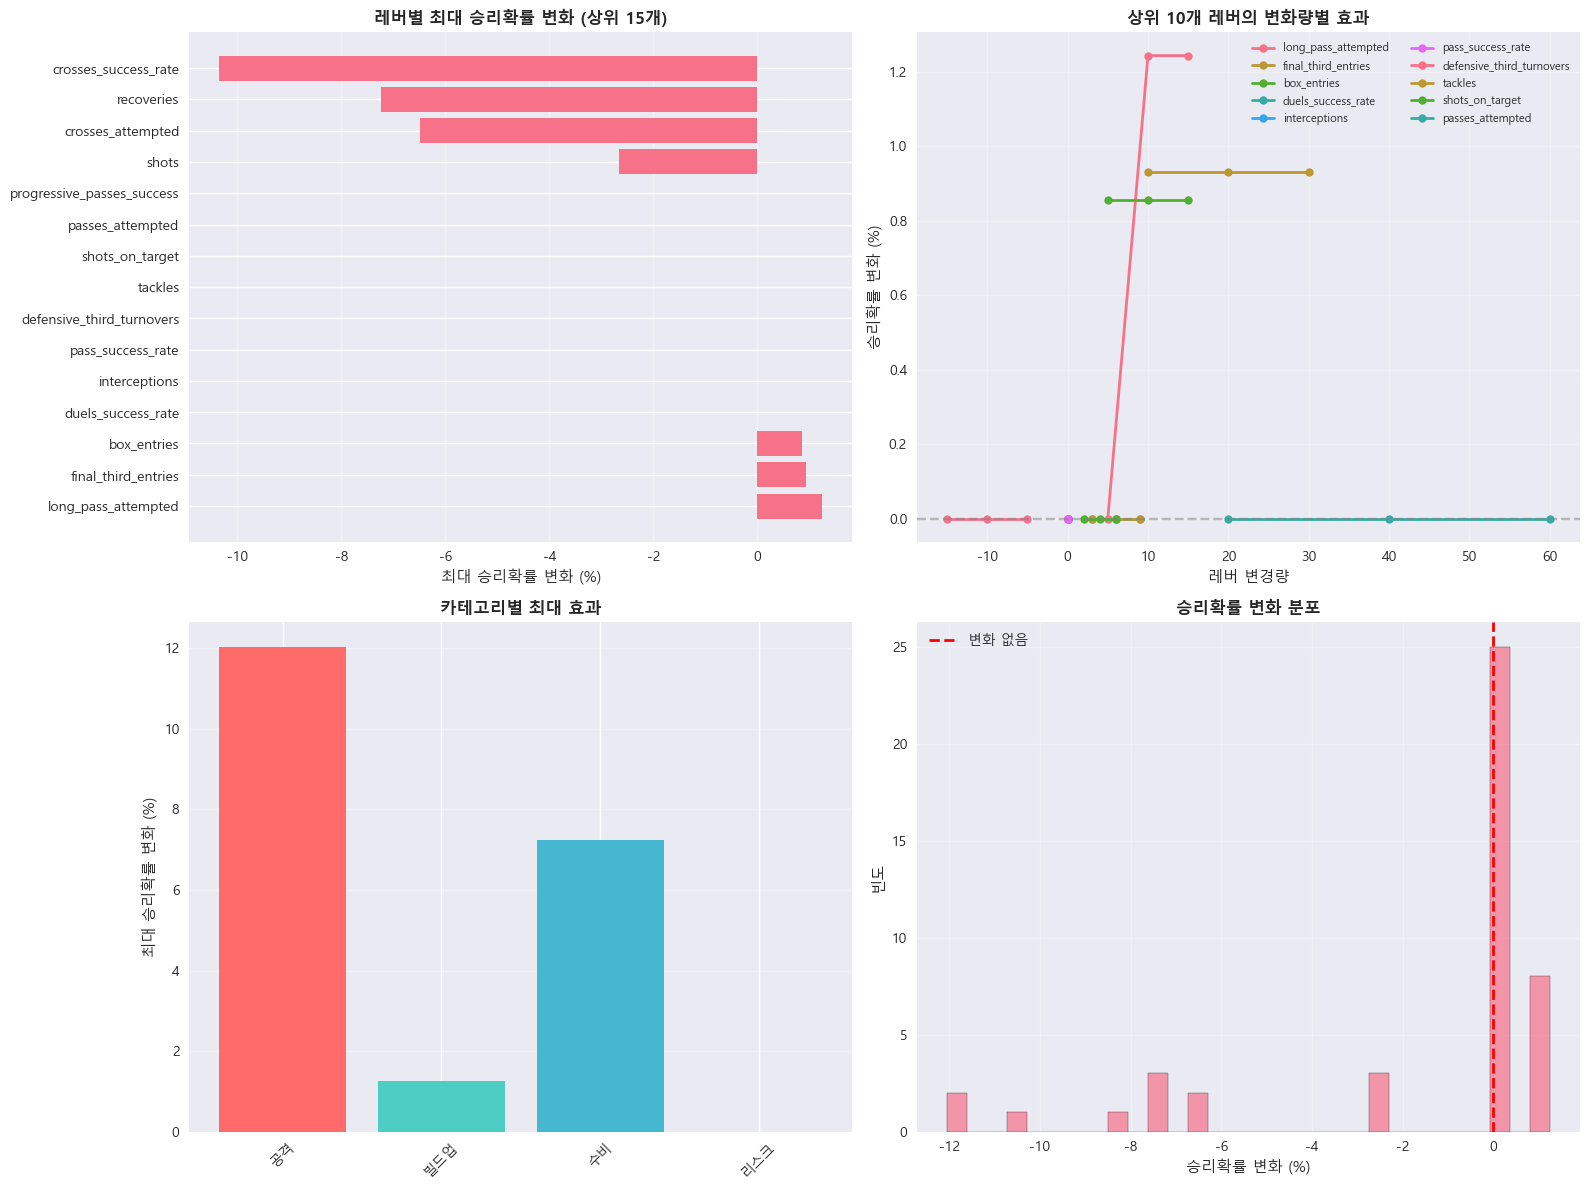


📈 전술 레버 시뮬레이션 통계 요약
총 테스트 레버 수: 15개
총 시뮬레이션 수: 45개
평균 승리확률 변화: -1.72%
최대 승리확률 증가: +1.24%
최대 승리확률 감소: -12.05%
표준편차: 3.70%


In [ ]:
# 시각화 (개선된 버전)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 레버별 최대 승리확률 변화 (상위 15개)
lever_summary = simulation_results.groupby('lever').agg({
    'prob_delta': 'max'
}).sort_values('prob_delta', ascending=False).head(15)

axes[0, 0].barh(lever_summary.index, lever_summary['prob_delta'] * 100)
axes[0, 0].set_xlabel('최대 승리확률 변화 (%)')
axes[0, 0].set_title('레버별 최대 승리확률 변화 (상위 15개)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. 상위 10개 레버의 변화량별 효과
top_levers = lever_summary.head(10).index
for lever in top_levers:
    lever_data = simulation_results[simulation_results['lever'] == lever].sort_values('change')
    axes[0, 1].plot(lever_data['change'], lever_data['prob_delta'] * 100, 
                marker='o', label=lever, linewidth=2, markersize=6)

axes[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('레버 변경량')
axes[0, 1].set_ylabel('승리확률 변화 (%)')
axes[0, 1].set_title('상위 10개 레버의 변화량별 효과', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=8, loc='best', ncol=2)
axes[0, 1].grid(alpha=0.3)

# 3. 카테고리별 평균 효과
categories = {
    '공격': ['shots', 'shots_on_target', 'box_entries', 'final_third_entries', 
            'progressive_passes_success', 'crosses_attempted', 'crosses_success_rate'],
    '빌드업': ['passes_attempted', 'pass_success_rate', 'long_pass_attempted'],
    '수비': ['recoveries', 'interceptions', 'tackles', 'duels_success_rate'],
    '리스크': ['defensive_third_turnovers']
}

category_effects = {}
for category, levers in categories.items():
    category_data = simulation_results[simulation_results['lever'].isin(levers)]
    if len(category_data) > 0:
        category_effects[category] = category_data['prob_delta'].abs().max() * 100

if category_effects:
    axes[1, 0].bar(category_effects.keys(), category_effects.values(), 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    axes[1, 0].set_ylabel('최대 승리확률 변화 (%)')
    axes[1, 0].set_title('카테고리별 최대 효과', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

# 4. 효과 분포 히스토그램
all_deltas = simulation_results['prob_delta'] * 100
axes[1, 1].hist(all_deltas, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='변화 없음')
axes[1, 1].set_xlabel('승리확률 변화 (%)')
axes[1, 1].set_ylabel('빈도')
axes[1, 1].set_title('승리확률 변화 분포', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 요약
print("\n" + "=" * 70)
print("📈 전술 레버 시뮬레이션 통계 요약")
print("=" * 70)
print(f"총 테스트 레버 수: {len(simulation_results['lever'].unique())}개")
print(f"총 시뮬레이션 수: {len(simulation_results)}개")
print(f"평균 승리확률 변화: {all_deltas.mean():+.2f}%")
print(f"최대 승리확률 증가: {all_deltas.max():+.2f}%")
print(f"최대 승리확률 감소: {all_deltas.min():+.2f}%")
print(f"표준편차: {all_deltas.std():.2f}%")


## 최종 통합: 매치 프리뷰 + 전술 시뮬레이션

모든 기능을 통합하여 완전한 매치 프리뷰 리포트를 생성합니다.


In [ ]:
def generate_complete_match_preview(team, opponent, team_match_features_df, 
                                   model, scaler, feature_cols, n_recent=5):
    """
    완전한 매치 프리뷰 생성 (승리확률 + 강점/약점 + 전술 레버 시뮬레이션)
    
    Returns:
        dict: 완전한 리포트
    """
    # 1. 기본 매치 프리뷰
    preview = generate_match_preview(
        team, opponent, team_match_features_df, None,
        model, scaler, feature_cols, n_recent
    )
    
    # 2. 매치업 피처 생성 (전술 시뮬레이션용)
    team_recent = team_match_features_df[
        team_match_features_df['team'] == team
    ].tail(n_recent)
    
    opponent_recent = team_match_features_df[
        team_match_features_df['opponent'] == opponent
    ].tail(n_recent)
    
    base_matchup = {}
    for col in feature_cols:
        base_metric = col.replace('diff_', '')
        if len(team_recent) > 0 and len(opponent_recent) > 0:
            team_val = team_recent[base_metric].mean() if base_metric in team_recent.columns else 0
            opponent_conceded = opponent_recent[base_metric].mean() if base_metric in opponent_recent.columns else 0
            base_matchup[col] = team_val - opponent_conceded
        else:
            base_matchup[col] = 0
    
    base_matchup_series = pd.Series(base_matchup)
    
    # 3. 전술 레버 시뮬레이션
    simulation = simulate_tactical_levers(
        base_matchup_series,
        model,
        scaler,
        feature_cols,
        team_match_features_df,
        levers={
            "box_entries": [+1, +2, +3],
            "shots_on_target": [+1, +2],
            "progressive_passes_success": [+2, +4],
            "defensive_third_turnovers": [-2, -4]
        }
    )
    
    # 4. 통합 리포트
    complete_report = {
        **preview,
        'tactical_simulation': simulation
    }
    
    return complete_report

# 완전한 리포트 생성 예시
print("=" * 70)
print("완전한 매치 프리뷰 리포트 생성")
print("=" * 70)

complete_report = generate_complete_match_preview(
    team="FC서울",
    opponent="강원FC",
    team_match_features_df=team_match_features,
    model=final_model,
    scaler=final_scaler if use_scaler else None,
    feature_cols=feature_cols,
    n_recent=5
)

print(f"\n{'='*70}")
print(f"📊 매치 프리뷰: {complete_report['team']} vs {complete_report['opponent']}")
print(f"{'='*70}")
print(f"\n🎯 기본 승리확률: {complete_report['win_probability']:.2%}")

print(f"\n💪 【{complete_report['team']} 강점】")
for metric, data in complete_report['team_strengths'].items():
    print(f"   • {metric}: 리그 평균 대비 +{data['diff']:.2f} ({data['diff_pct']:.1f}%)")

print(f"\n⚠️ 【{complete_report['opponent']} 약점】")
for metric, data in complete_report['opponent_weaknesses'].items():
    print(f"   • {metric}: 리그 평균 대비 +{data['diff']:.2f} 허용")

print(f"\n🔑 【핵심 매치업 어드밴티지】")
if complete_report['matchup_advantages']:
    for adv in complete_report['matchup_advantages']:
        print(f"   • {adv['metric']}: 강점과 약점이 겹치는 핵심 지표")
else:
    print("   • 겹치는 강점/약점이 없습니다.")

print(f"\n⚙️ 【전술 레버 시뮬레이션】")
sim_df = complete_report['tactical_simulation']
for lever in sim_df['lever'].unique():
    lever_data = sim_df[sim_df['lever'] == lever]
    max_effect = lever_data.loc[lever_data['prob_delta'].idxmax()]
    print(f"   • {lever}: 최대 효과 {max_effect['change']:+d} → 승리확률 {max_effect['prob_delta']:+.2%}p 증가")

print(f"\n{'='*70}")
print("✅ 리포트 생성 완료!")
print(f"{'='*70}")


완전한 매치 프리뷰 리포트 생성

[디버깅] diff_box_entries:
  base_value: -3.6000
  change: 1
  new_value: -2.6000
  base_prob: 0.518232
  new_prob: 0.518232
  prob_delta: 0.000000

📊 매치 프리뷰: FC서울 vs 강원FC

🎯 기본 승리확률: 51.82%

💪 【FC서울 강점】
   • tackles: 리그 평균 대비 +5.82 (24.2%)
   • interceptions: 리그 평균 대비 +1.22 (3.5%)
   • duels_success_rate: 리그 평균 대비 +0.00 (0.0%)

⚠️ 【강원FC 약점】
   • box_entries: 리그 평균 대비 +3.27 허용

🔑 【핵심 매치업 어드밴티지】
   • 겹치는 강점/약점이 없습니다.

⚙️ 【전술 레버 시뮬레이션】
   • box_entries: 최대 효과 +1 → 승리확률 +0.00%p 증가
   • shots_on_target: 최대 효과 +1 → 승리확률 +0.00%p 증가
   • progressive_passes_success: 최대 효과 +2 → 승리확률 +0.00%p 증가
   • defensive_third_turnovers: 최대 효과 -2 → 승리확률 +0.00%p 증가

✅ 리포트 생성 완료!


: 

## 사용법 요약

이 노트북을 실행하면:

1. ✅ **팀별 경기별 피처 테이블** 생성 (`team_match_features.csv`)
2. ✅ **매치업 피처** 계산 (`matchup_features.csv`)
3. ✅ **승리확률 모델** 학습 (Logistic Regression + LightGBM)
4. ✅ **강점/약점 분석** 리포트 생성
5. ✅ **전술 레버 시뮬레이션** (What-if 분석)

### 다음 단계로 사용하기

```python
# 특정 팀 매치업 분석
report = generate_complete_match_preview(
    team="FC서울",
    opponent="강원FC",
    team_match_features_df=team_match_features,
    model=final_model,
    scaler=final_scaler if use_scaler else None,
    feature_cols=feature_cols,
    n_recent=5
)

# 승리확률 확인
print(f"승리확률: {report['win_probability']:.2%}")

# 전술 레버 효과 확인
print(report['tactical_simulation'])
```
